# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [1]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = True

In [2]:
%load_ext autoreload
%autoreload 2

# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if cuda else "cpu")

# Local imports
from acts import process_hits_files, select_barrel_hits, select_hits
from graph import load_graphs, SparseGraph, graph_from_sparse
from model import SegmentClassifier
from estimator import Estimator

feature_scale = np.array([1000., np.pi/8, 1000.])

n_features = feature_scale.shape[0]

%matplotlib notebook

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False))

if cuda:
    torch_to_np = lambda x: x.cpu().numpy()
else:
    torch_to_np = lambda x: x.detach().numpy()

## Data utilities

## Prepare the data

In [4]:
#input_dir = '/data/ntran/prod_mu10_pt1000_2017_07_29'
#input_dir = '/cms-sc17/graphNN/prod_mu10_pt1000_2017_07_29'
input_dir = 'trackml-graphs/'

In [6]:
%%time
n_samples = 800
filenames = [os.path.join(input_dir, 'graph%06i.npz' % i) for i in range(n_samples)]
graphs = load_graphs(filenames, SparseGraph)

CPU times: user 1.78 s, sys: 32 ms, total: 1.82 s
Wall time: 2.16 s


In [7]:
# Get the mean label for all the segments from all samples

# Flatten the labels array
flat_y = np.concatenate([g.y for g in graphs])

flat_y.mean()

0.62073225

## Define the data generator

Since every event is unique, we need something which can batch things together into batch-specific tensors.

It should just use the max size required for that sample.

In [8]:
def merge_graphs(graphs):
    batch_size = len(graphs)
    
    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        return g.X[None], g.Ri[None], g.Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [graph_from_sparse(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            #print('  data prepared')
            yield batch_inputs, batch_target

### Visualize one sample

Need to put this code into a function, and write it so it will be easy to use
at model evaluation time (e.g., using model representation of the data).

In [36]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    """
    TODO: make segment coloring configurable.
    """
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    ax1.set_xlim(-np.pi/8, np.pi/8)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

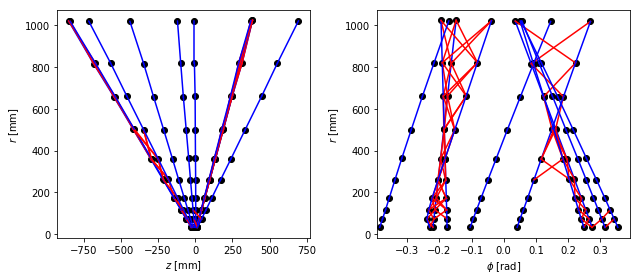

In [37]:
# Pull the inputs from the batcher
g = graph_from_sparse(graphs[0])
draw_sample(g.X*feature_scale, g.Ri, g.Ro, g.y)

## Train the model

In [69]:
# Model config
hidden_dim = 32
n_iters = 4

# Training config
batch_size = 32
n_epochs = 100
valid_frac = 0.2
test_frac = 0.2

In [70]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(480, 160, 160, 800)

In [71]:
# Partition the dataset
train_graphs, test_graphs = train_test_split(graphs, test_size=n_test)
train_graphs, valid_graphs = train_test_split(train_graphs, test_size=n_valid)

print('Train set size:', len(train_graphs))
print('Valid set size:', len(valid_graphs))
print('Test set size: ', len(test_graphs))

Train set size: 480
Valid set size: 160
Test set size:  160


In [72]:
# Prepare the batch generators
train_batcher = batch_generator(train_graphs, n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_graphs, n_samples=n_valid, batch_size=batch_size, train=False)

In [42]:
threshold = .001
%matplotlib inline

model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters, masks_e=None, masks_n=None)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1 = 0)
estim.load_checkpoint('/home/sjenkins/ML/gnn-fpga-v2/gnn/Prune/0v2.pt')

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    #print(model.edge_network.network[0].weight)
    #print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')


    arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    
    
    # Node Networks
    arr_n = torch_to_np(model.node_network.network[0].weight)
    #print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')

    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    #print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')
    
    mask_e = [np_to_torch(arr_e), np_to_torch(arr_e2)]
    mask_n = [np_to_torch(arr_n), np_to_torch(arr_n2)]

2018-07-26 13:17:20.568798 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=70, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=105, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
)
2018-07-26 13:17:20.569993 Parameters: 6881


FileNotFoundError: [Errno 2] No such file or directory: '/home/sjenkins/ML/gnn-fpga-v2/gnn/Prune/0v2.pt'

In [73]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)# masks_e=mask_e, masks_n=mask_n)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1= 0)

2018-07-26 13:28:17.401392 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=70, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=105, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
)
2018-07-26 13:28:17.401615 Parameters: 6881


In [23]:
estim.load_checkpoint('/home/sjenkins/ML/gnn-fpga-v2/gnn/Prune/00005v2.pt')

In [75]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
              filename='Prune/pruned1e-5mask.pt')

2018-07-26 13:28:25.702287 Epoch 0
2018-07-26 13:28:26.082405   training loss 0.664 time 0.379993s
2018-07-26 13:28:26.134534   validate loss 0.611
2018-07-26 13:28:26.134798  save checkpoint
2018-07-26 13:28:26.137265 Epoch 1
2018-07-26 13:28:26.455327   training loss 0.57 time 0.317987s
2018-07-26 13:28:26.501517   validate loss 0.537
2018-07-26 13:28:26.501740  save checkpoint
2018-07-26 13:28:26.504113 Epoch 2
2018-07-26 13:28:26.793951   training loss 0.523 time 0.289764s
2018-07-26 13:28:26.839734   validate loss 0.503
2018-07-26 13:28:26.839817  save checkpoint
2018-07-26 13:28:26.842300 Epoch 3
2018-07-26 13:28:27.131275   training loss 0.493 time 0.288755s
2018-07-26 13:28:27.177023   validate loss 0.477
2018-07-26 13:28:27.177091  save checkpoint
2018-07-26 13:28:27.179581 Epoch 4
2018-07-26 13:28:27.468110   training loss 0.468 time 0.288452s
2018-07-26 13:28:27.513706   validate loss 0.453
2018-07-26 13:28:27.513774  save checkpoint
2018-07-26 13:28:27.516525 Epoch 5
2018-0

2018-07-26 13:28:40.673473   training loss 0.242 time 0.288866s
2018-07-26 13:28:40.719473   validate loss 0.242
2018-07-26 13:28:40.719968  save checkpoint
2018-07-26 13:28:40.722491 Epoch 44
2018-07-26 13:28:41.011616   training loss 0.237 time 0.28904s
2018-07-26 13:28:41.057420   validate loss 0.24
2018-07-26 13:28:41.057505  save checkpoint
2018-07-26 13:28:41.060376 Epoch 45
2018-07-26 13:28:41.349659   training loss 0.231 time 0.289194s
2018-07-26 13:28:41.395571   validate loss 0.233
2018-07-26 13:28:41.395652  save checkpoint
2018-07-26 13:28:41.398935 Epoch 46
2018-07-26 13:28:41.688131   training loss 0.226 time 0.289111s
2018-07-26 13:28:41.734077   validate loss 0.229
2018-07-26 13:28:41.734173  save checkpoint
2018-07-26 13:28:41.737600 Epoch 47
2018-07-26 13:28:42.030075   training loss 0.222 time 0.292391s
2018-07-26 13:28:42.076211   validate loss 0.224
2018-07-26 13:28:42.076301  save checkpoint
2018-07-26 13:28:42.080101 Epoch 48
2018-07-26 13:28:42.370533   training

2018-07-26 13:28:55.183988   training loss 0.155 time 0.287684s
2018-07-26 13:28:55.229483   validate loss 0.158
2018-07-26 13:28:55.229545  save checkpoint
2018-07-26 13:28:55.231917 Epoch 87
2018-07-26 13:28:55.519378   training loss 0.151 time 0.287391s
2018-07-26 13:28:55.565188   validate loss 0.155
2018-07-26 13:28:55.565251  save checkpoint
2018-07-26 13:28:55.567861 Epoch 88
2018-07-26 13:28:55.856059   training loss 0.15 time 0.287978s
2018-07-26 13:28:55.901564   validate loss 0.154
2018-07-26 13:28:55.901643  save checkpoint
2018-07-26 13:28:55.904292 Epoch 89
2018-07-26 13:28:56.192914   training loss 0.149 time 0.28855s
2018-07-26 13:28:56.238520   validate loss 0.153
2018-07-26 13:28:56.238583  save checkpoint
2018-07-26 13:28:56.241225 Epoch 90
2018-07-26 13:28:56.529120   training loss 0.15 time 0.287824s
2018-07-26 13:28:56.574700   validate loss 0.152
2018-07-26 13:28:56.574943  save checkpoint
2018-07-26 13:28:56.577406 Epoch 91
2018-07-26 13:28:56.866969   training 

In [ ]:
#estim.load_checkpoint('/home/sjenkins/ML/gnn-fpga-v2/gnn/Prune/0001.pt')

### Loss curves

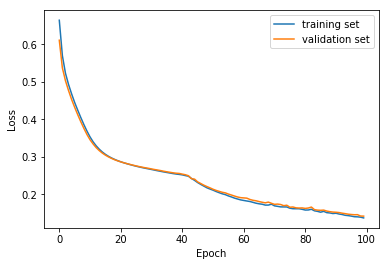

In [76]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim(40,60)
#plt.ylim(.0767,.0773)
plt.legend(loc=0);

## Evaluate model on the test set

In [35]:
if cuda:
    torch.cuda.empty_cache()

In [98]:
estim.load_checkpoint('/home/sjenkins/ML/gnn-fpga-v2/gnn/Prune/001.pt')

In [50]:
# prepare test generator
with torch.no_grad():
    test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)
    test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
    test_preds = [torch_to_np(o) for o in test_outputs]

    # Flatten the predictions and labels
    flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
    flat_pred = np.concatenate([p.flatten() for p in test_preds])
    print(flat_y.shape)
    print(flat_pred.shape)

(22836,)
(22836,)


In [77]:
def makeROC(flat_y, flat_pred, thresh=0.5):
    
    print('Test set results with threshold of', thresh)
    print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
    print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
    print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))
    
    # Compute the ROC curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
    
    plt.figure(figsize=(12,3))

    # Plot the model outputs
    plt.subplot(131)
    binning=dict(bins=50, range=(0,1), histtype='bar')
    plt.hist(flat_pred[flat_y<thresh], label='fake', **binning)
    plt.hist(flat_pred[flat_y>thresh], label='true', **binning)
    #plt.xlim(.1,.125)
    plt.xlim(0, 1)
    plt.xlabel('Model output')
    plt.legend(loc=0)

    # Plot the ROC curve
    plt.subplot(132)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.title('ROC curve')

    # Plot the ROC curve
    plt.subplot(133)
    plt.semilogx(fpr, tpr)
    #plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim(0, 1)
    plt.xlim(1e-6, 1)
    plt.title('ROC curve')

    plt.tight_layout()

BEFORE Masking
Test set results with threshold of 0.5
Accuracy:  0.7830
Precision: 0.8840
Recall:    0.7546


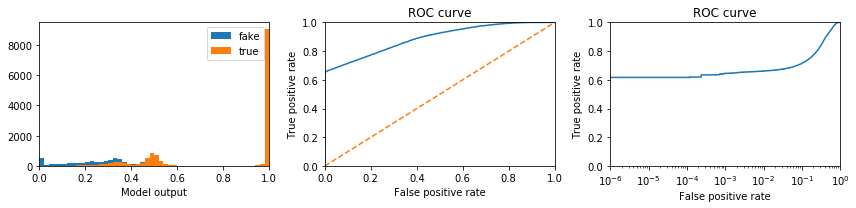

In [78]:
print('BEFORE Masking')
makeROC(flat_y, flat_pred)

In [49]:
#mask

'''threshold = .001
%matplotlib inline

def summer(arr, net_name):
    arr_f = arr.flatten()
    sum_n = sum(arr_f)
    print(net_name, 'Network Sum:', sum_n)

with torch.no_grad():
    # Edge Networks
    print(model.edge_network.network[0].weight)
    print(model.edge_network.network[0].weight.shape)
    arr_e = torch_to_np(model.edge_network.network[0].weight)
    arr_e = (np.abs(arr_e) > threshold)*1
    summer(arr_e, 'Edge')
    # mask
    masked_weight = torch.nn.Parameter(model.edge_network.network[0].weight * np_to_torch(arr_e))
    model.edge_network.network[0].weight = masked_weight
    print(model.edge_network.network[0].weight)

    arr_e2 = torch_to_np(model.edge_network.network[2].weight)
    # Original size = 32
    arr_e2 = (np.abs(arr_e2) > threshold)*1
    summer(arr_e2, 'Edge2')
    # mask
    masked_weight = torch.nn.Parameter(model.edge_network.network[2].weight * np_to_torch(arr_e2))
    model.edge_network.network[2].weight = masked_weight
    
    # Node Networks
    arr_n = torch_to_np(model.node_network.network[0].weight)
    print(model.node_network.network[0].weight.shape)
    arr_n = (np.abs(arr_n) > threshold)*1
    summer(arr_n, 'Node')
    # mask
    masked_weight = torch.nn.Parameter(model.node_network.network[0].weight * np_to_torch(arr_n))
    model.node_network.network[0].weight = masked_weight
    
    arr_n2 = torch_to_np(model.node_network.network[2].weight)
    print(model.node_network.network[2].weight.shape)
    arr_n2 = (np.abs(arr_n2) > threshold)*1
    summer(arr_n2, 'Node2')
    # mask
    masked_weight = torch.nn.Parameter(model.node_network.network[2].weight * np_to_torch(arr_n2))
    model.node_network.network[2].weight = masked_weight'''

Parameter containing:
tensor([[ 1.7495e-04,  1.4459e-04,  1.1631e-04,  ..., -1.8033e-02,
         -3.2216e+00,  1.7406e-03],
        [-1.0978e-04,  1.0230e-04,  4.1613e-05,  ...,  1.6546e-02,
         -7.1849e-01, -1.9874e-03],
        [ 2.1522e-04, -3.0008e-04, -1.6043e-04,  ...,  3.0286e-04,
         -6.5783e-02,  4.0403e-04],
        ...,
        [-2.6454e-04, -9.3102e-05, -3.3954e-05,  ..., -6.4469e-05,
          2.5793e-07, -1.9129e-06],
        [ 2.3279e-04,  3.5655e-06,  5.0537e-05,  ..., -8.6343e-05,
          5.6277e-05,  7.6040e-05],
        [-8.9185e-05, -4.6916e-05, -2.2985e-05,  ..., -6.2400e-05,
         -1.4161e-04, -4.3004e-05]])
torch.Size([32, 70])
Edge Network Sum: 372
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0180, -3.2216,  0.0017],
        [-0.0000,  0.0000,  0.0000,  ...,  0.0165, -0.7185, -0.0020],
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0658,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000

In [79]:
%matplotlib inline
 
def plotLayerWeights(layer, plotTitle='Network'):
    with torch.no_grad():
        arr = torch_to_np(layer.weight)
        arr = arr.flatten()

        plt.figure(figsize=(4,4))

        #plt.subplot(2,2,1)
    
        #plt.hist(arr, bins=100, range=(-.0002,.0002))
        #plt.xlabel('Weight')
        #plt.ylabel('Frequency')
        #plt.title('Network')

        #plt.subplot(2,2,2)
        #plt.hist(np.abs(arr), bins=100, range=(0,.0002))
        #plt.xlabel('|Weight|')
        #plt.ylabel('Frequency')
        #plt.title('Network-Absolute Value')

        #plt.subplot(2,2,3)
        #plt.hist(np.abs(arr), bins=1000, range=(2**-11, 2**-0))
        #plt.xscale('log',basex=2)
        #plt.xlim([2**-13,2**-4])
        #plt.xlabel('Weight')
        #plt.ylabel('Frequency')
        #plt.title('Network-Log2')
    
        #plt.subplot(2,2,4)
        #arr_n = [np.log(x) for x in arr_n]
        logbins = np.geomspace(10**-4, 1, 100)
        plt.hist(np.abs(arr), logbins)
        plt.xscale('log',basex=10)
        plt.xlabel('|Weight|')
        plt.ylabel('Frequency')
        plt.title(plotTitle)

        plt.show()

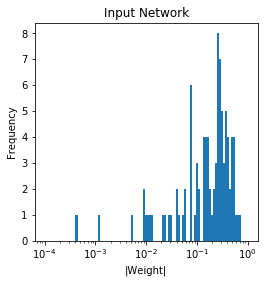

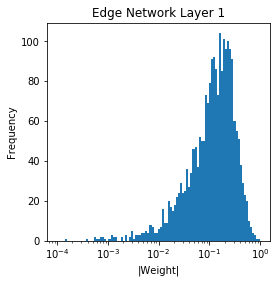

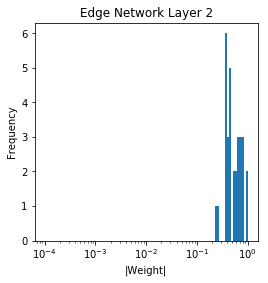

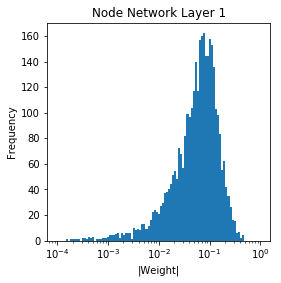

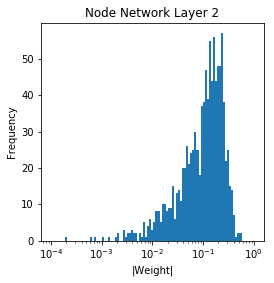

In [80]:
## NETWORKS 
plotLayerWeights(model.input_network[0], plotTitle='Input Network')
plotLayerWeights(model.edge_network.network[0], plotTitle='Edge Network Layer 1')
plotLayerWeights(model.edge_network.network[2], plotTitle='Edge Network Layer 2')
plotLayerWeights(model.node_network.network[0], plotTitle='Node Network Layer 1')
plotLayerWeights(model.node_network.network[2], plotTitle='Node Network Layer 2')

## Visualize some samples

In [ ]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i], alpha_labels=True);

## Visualize evolution of graph iterations

Let's take a sample and pull out the intermediate edge scores during graph iterations.
I'd like to visualize how the model converges on its chosen edges.

In [ ]:
def graph_iter(model, X, H, Ri, Ro):
    # Shortcut connections
    H = torch.cat([H, X], dim=-1)
    # Edge network
    e = model.edge_network(H, Ri, Ro)
    # Node network
    H = model.node_network(H, e, Ri, Ro)
    return e, H

In [10]:
batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                          n_samples=1, batch_size=1)

NameError: name 'test_X' is not defined

In [ ]:
model = estim.model

In [ ]:
# Pull the inputs from the batcher
(X, Ri, Ro), y = next(batcher)

In [ ]:
# Apply input network
with torch.no_grad():
    H = model.input_network(X)

    for i in range(model.n_iters + 1):
        # Apply an iteration of the graph
        e, H = graph_iter(model, X, H, Ri, Ro)

        # Draw the edges
        draw_sample(torch_to_np(X)[0]*feature_scale,
                    torch_to_np(Ri)[0], torch_to_np(Ro)[0],
                    torch_to_np(e)[0], alpha_labels=True)

## Discussion

On 10 tracks and 10 barrel layers, the performance is great!